# Rossmann store sales data wrangling

### Background

Rossmann  operates  over  3,000  drug  stores  in  7  European  countries.  
Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks   in   advance.   
Store   sales   are   influenced   by   many   factors,   including promotions, competition, school and state holidays,
seasonality, and locality.

### Problem Statement

Predict 6 weeks of daily sales for 1115 drug stores operated by Rossmann located across Germany to enable store managers
to create effective staff schedules that increase productivity and motivation. 

In [1]:
import pandas as pd
import numpy as np
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# importing the dataset
train = pd.read_csv('train.csv', parse_dates = True, index_col = 'Date')
test = pd.read_csv('test.csv')
store = pd.read_csv('store.csv')

C:\Users\kanda\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print("Training Data :", train.shape)
print("Test Data :", test.shape)
print("Store Data :", store.shape)

Training Data : (1017209, 8)
Test Data : (41088, 8)
Store Data : (1115, 10)


In [4]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


##### Data field discussion

- Sales: the turnover for any given day (target variable).
- Customers: the number of customers on a given day.
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. 
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

## Data Extraction

In [5]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
# Adding new variable
train['SalesPerCustomer'] = train['Sales'] / train['Customers']
train['SalesPerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64

From above data we can conclude that maximum sale per customer is EURO 64.95 and minimum sale is EURO 0.

### Dealing with Missing values and other factors

#### Closed Stores and Zero sales stores

In [6]:
closed_stores_zero_sales =  train[(train.Open == 0) & (train.Sales == 0)]
closed_stores_zero_sales.shape

(172817, 13)

There are about 172817 closed stores in the data and it is about 10 % of total data. So, to avoid any biased factor we will drop these values.

#### Open stores with zero sales

In [7]:
open_stores_zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
open_stores_zero_sales.shape

(54, 13)

Only 54 days in this data when there is no sale on working day. so we can assume that there were external factors involved

So, Remove the data of closed stores and days which didn't have any sale

In [8]:
train = train[(train.Open != 0) & (train.Sales != 0)]
train.shape

(844338, 13)

### Analysis of  Store information

In [9]:
# Additional information about stores
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


#### Data Field
- Store: a unique Id for each store
- StoreType: differentiates between 4 different store models: a, b, c, d
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance: distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
- Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g.  --                      "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### Dealing with missing values of Store data

In [10]:
# Missing values
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [11]:
# Missing values in CompetitionDistance            
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


So, in CompetitionDistance replace NaN with median value because there is no paticular pattern.

In [12]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

if there's no Promo2 then there's no information about it. We can replace these values by zeros. The same goes for tha variables deducted from the competition, CompetitionOpenSinceMonth and CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear, PromoInterval.

In [13]:
# Fill all NaN with zeros
store.fillna(0, inplace = True)

In [14]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


## Exploratory Data Analysis

## Distribution of Sales and Customers

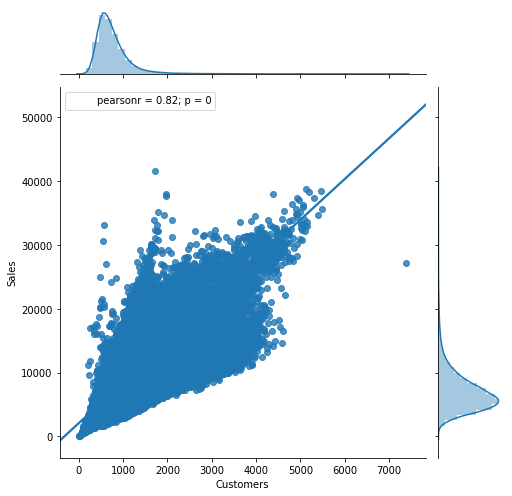

In [15]:
sns.jointplot(x="Customers" , y="Sales" , data = train, kind = "reg" , size=7)

### Correlational Analysis

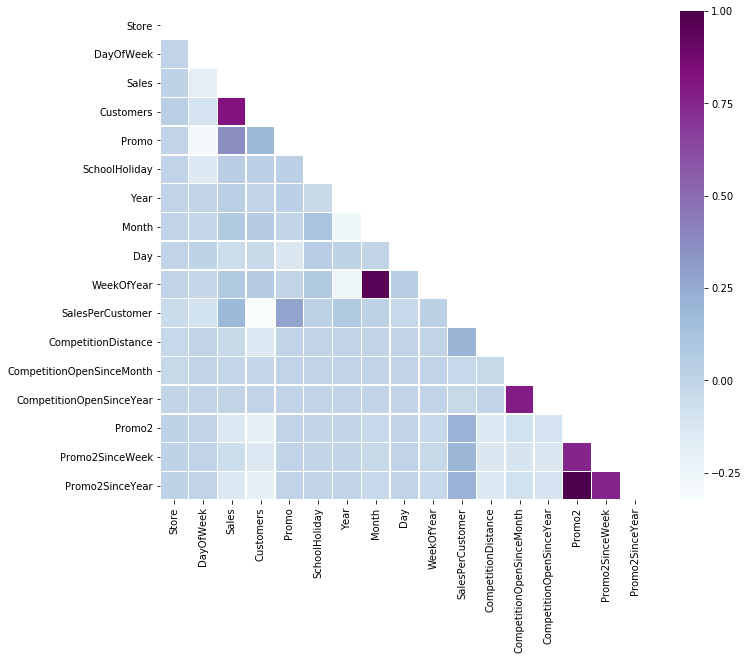

In [16]:
# HeatMap
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

Relationship between two columns.

the amount of Sales and Customers of a store

promotion (Promo equal to 1) and amount of Customers

## Store Types

In this section, we will look at different types of Stores and how sales is distributed among stores.

print an overall sum of Sales and Customers to see which StoreType is the most selling and crowded one:

In [17]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


Clearly, StoreType A is most selling and crowded one.

## Promo - Sales trend Analysis with StoreTypes

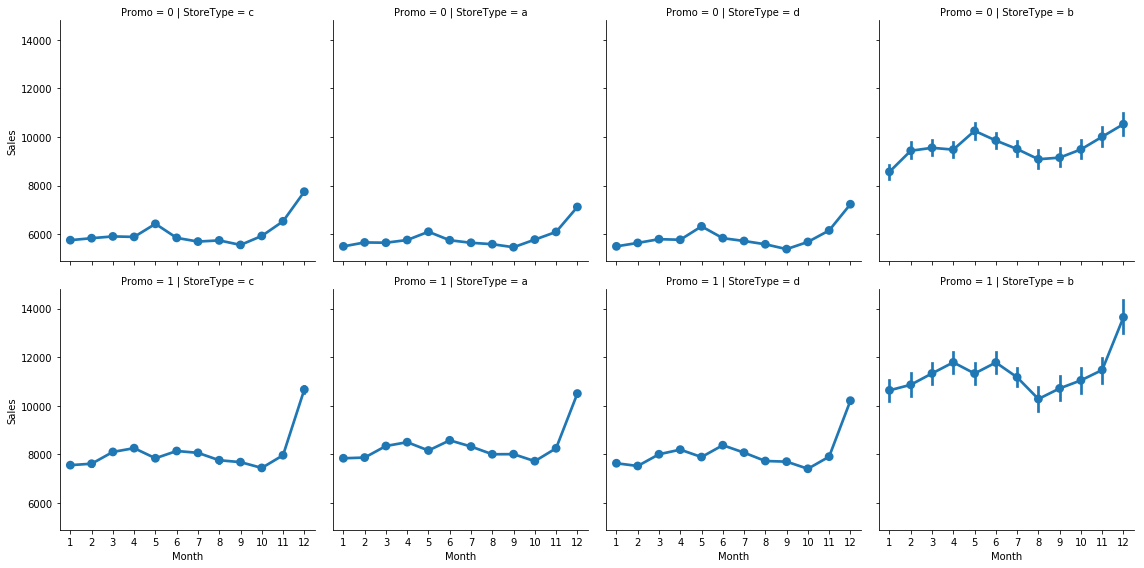

In [18]:
# Sales Trends
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               row = 'Promo', # per promo in the store in rows
               col = 'StoreType', # per store type in col
               )

Promo has significant effect on sales of each store.

##  Promo - Customers trend Analysis with StoreTypes

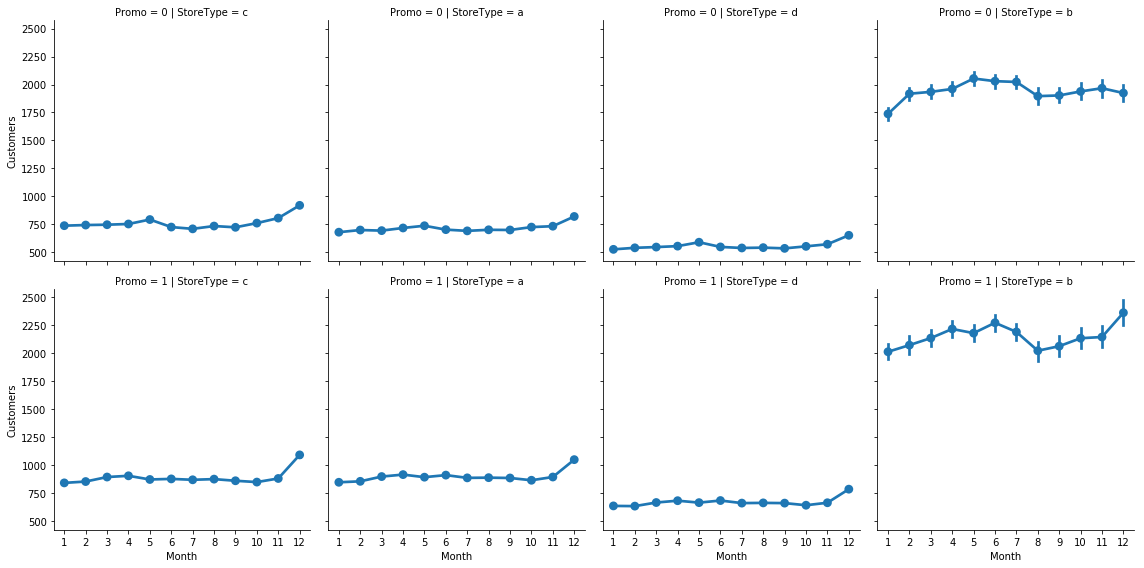

In [19]:

sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               row = 'Promo', # per promo in the store in rows
               col = 'StoreType', # per store type in col
               ) 

All store types follow the same trend but at different scales depending on the presence of the Promo and StoreType itself.

## Sales per customer Trends

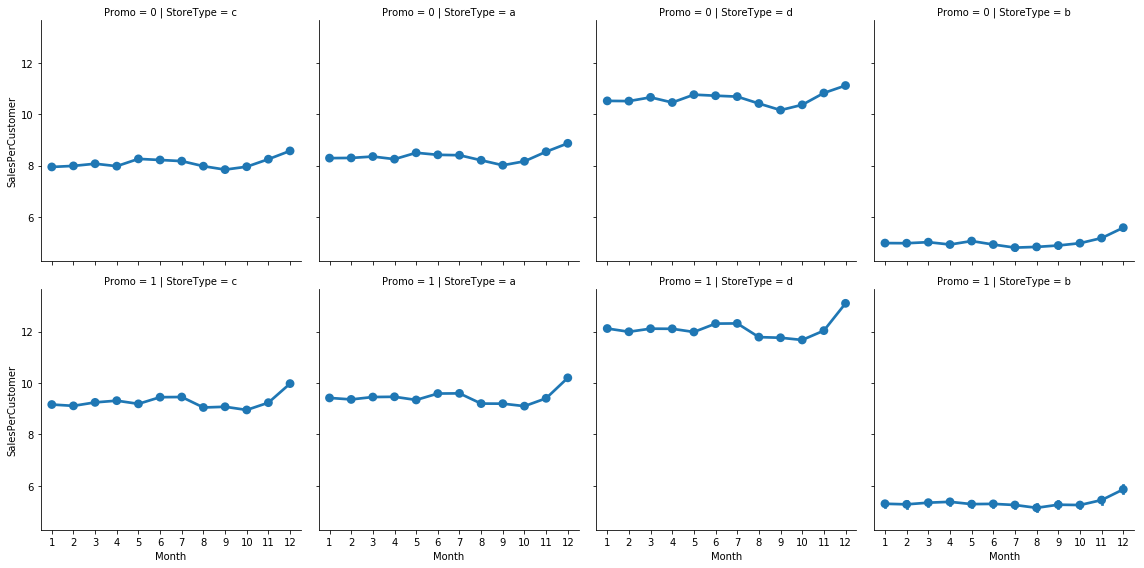

In [20]:
# Sales per customer Trends
sns.factorplot(data = train_store, x = 'Month', y = "SalesPerCustomer", 
               row = 'Promo', # per promo in the store in rows
               col = 'StoreType', # per store type in col
               ) 

The highest SalePerCustomer amount is observed at the StoreType D.

Low SalePerCustomer amount for StoreType B describes its Buyer Cart: there are a lot of people who shop essentially for "small" things (or in a little quantity).

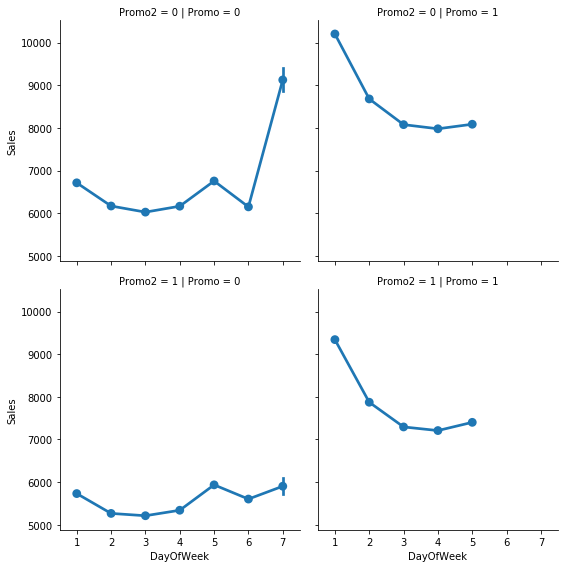

In [21]:
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               row = 'Promo2',
               col = 'Promo', 
              ) 

Customers tends to buy more on Monday (1) when there's one promotion (Promo) and on Sunday (7) when there's no promotion at all (both Promo and Promo1 are equal to 0).

## Stores sales according to DayOf Week

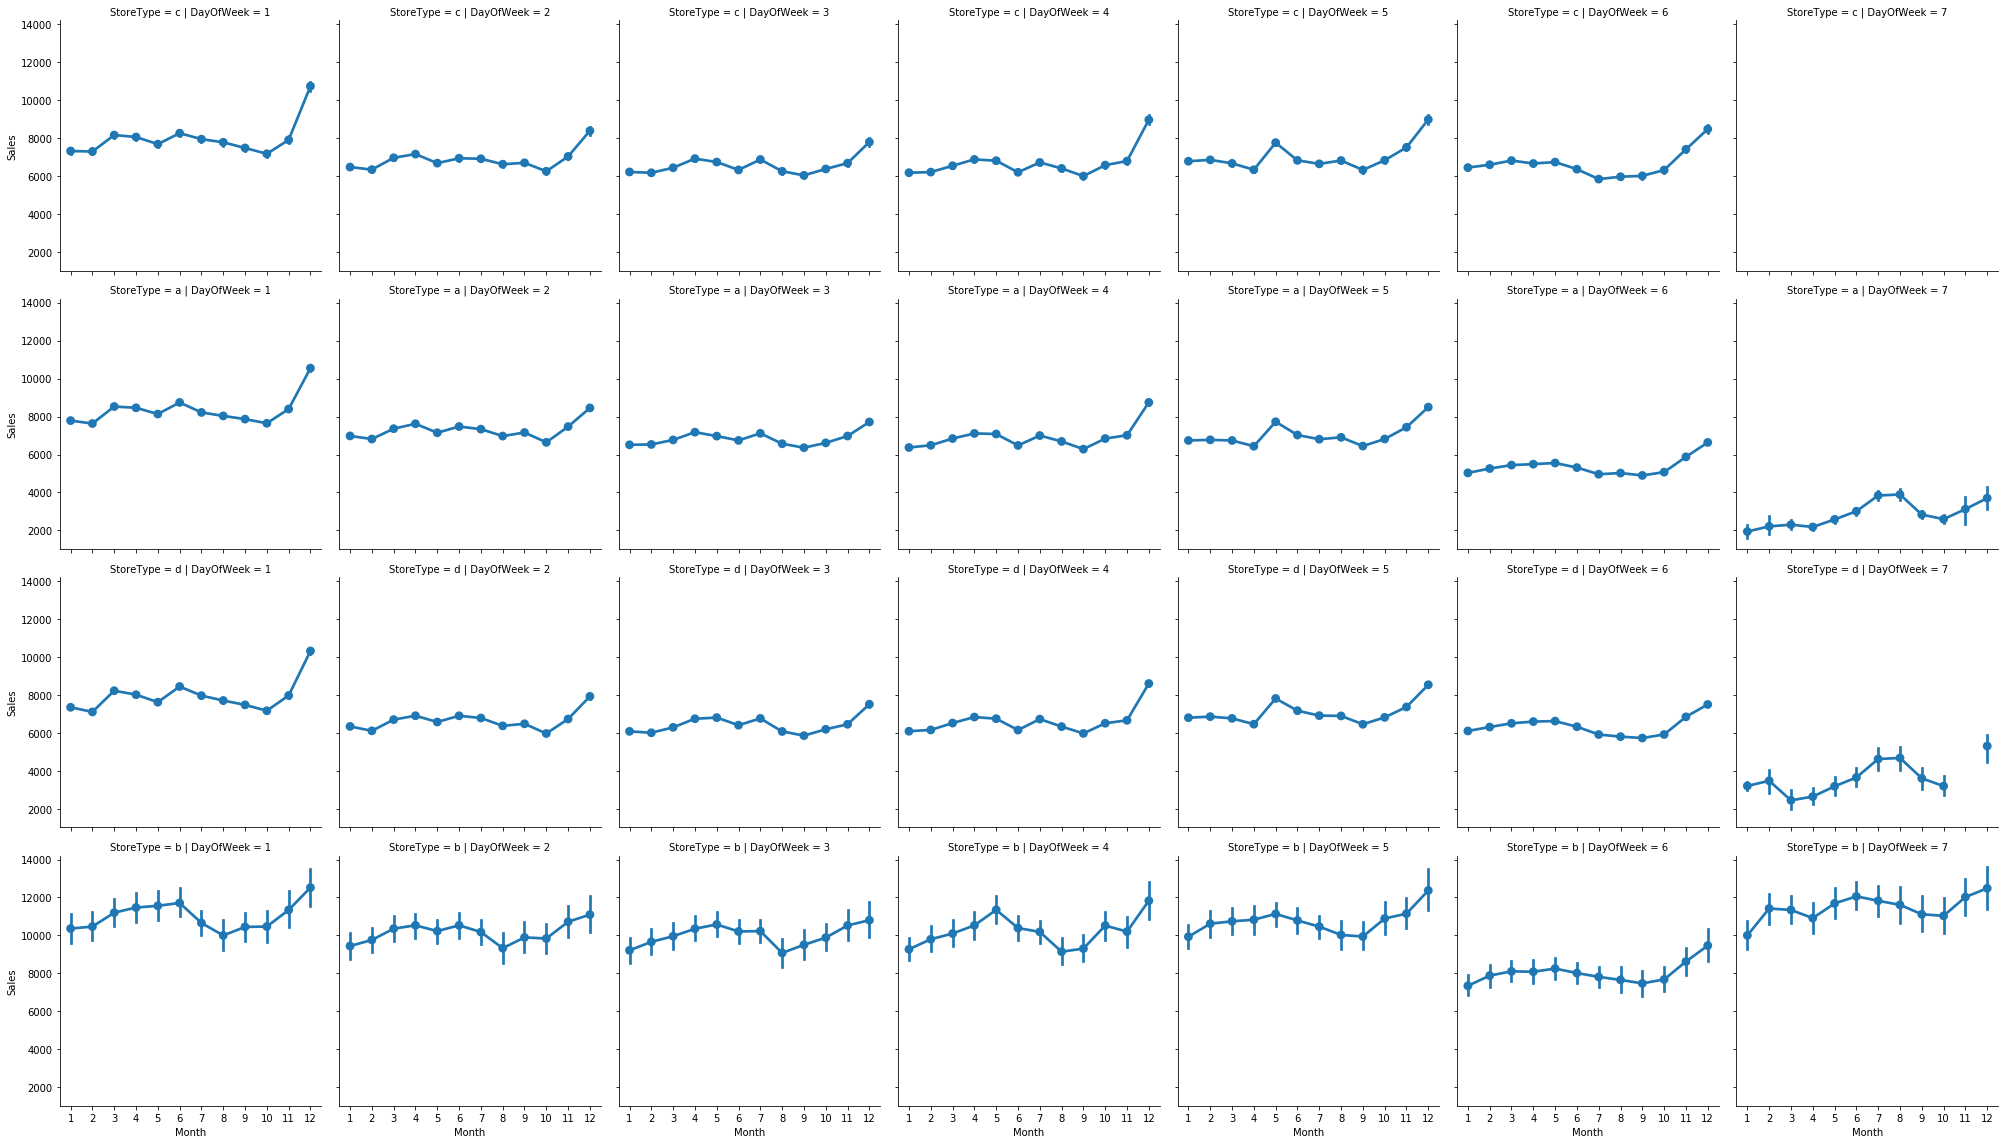

In [22]:
# Stores according to Day Of Week
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               row = 'StoreType', # per promo in the store in rows
               col = 'DayOfWeek', # per store type in col
               ) 

We see that stores of StoreType C are all closed on Sundays, whereas others are most of the time opened. 

Interestingly enough, stores of StoreType D are closed on Sundays only from October to December.


## Sales affected by assorment for each types of store

In [23]:
#sales affected by assorment for each types of store.
train_store.groupby(['StoreType', 'Assortment']).Sales.mean()

StoreType  Assortment
a          a              6538.189027
           c              7573.822775
b          a             11133.992979
           b              8642.503594
           c             17969.556263
c          a              6835.748557
           c              7037.913129
d          a              6433.756093
           c              7043.534764
Name: Sales, dtype: float64

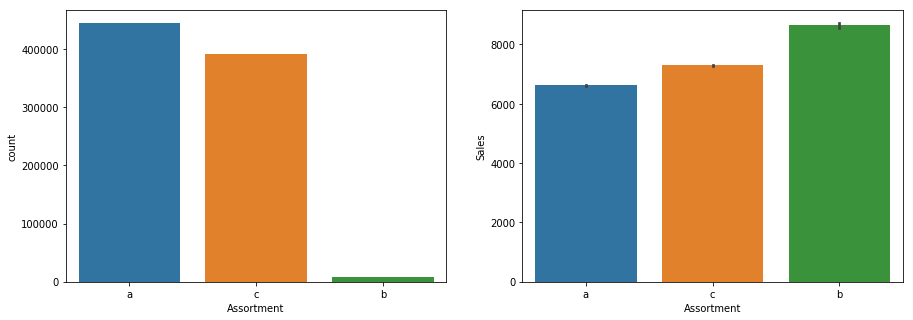

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.countplot(x='Assortment', data=train_store)
plt.subplot(122)
sns.barplot(x='Assortment', y='Sales', data=train_store)

For every store there are definite assortment types and for each assortment there is a different sales value.Although b assortment type appears to make more sales value, they are very rare compared to other types. 

Assortment - describes an assortment level: a = basic, b = extra, c = extended

## Sales affected by Competition distance

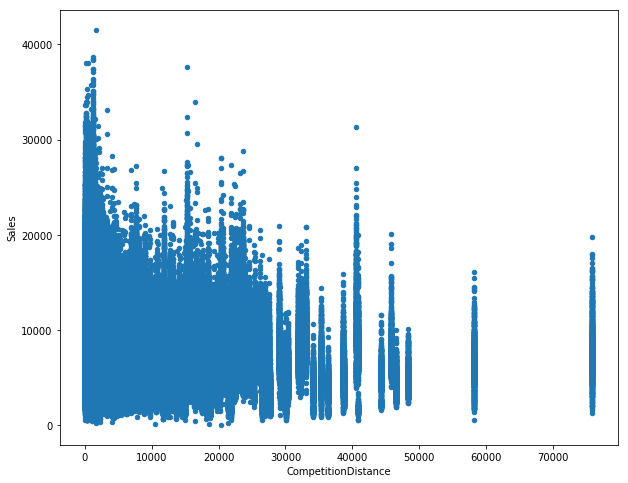

In [25]:
train_store.plot.scatter(x='CompetitionDistance', y='Sales', legend=True, figsize=(10, 8))

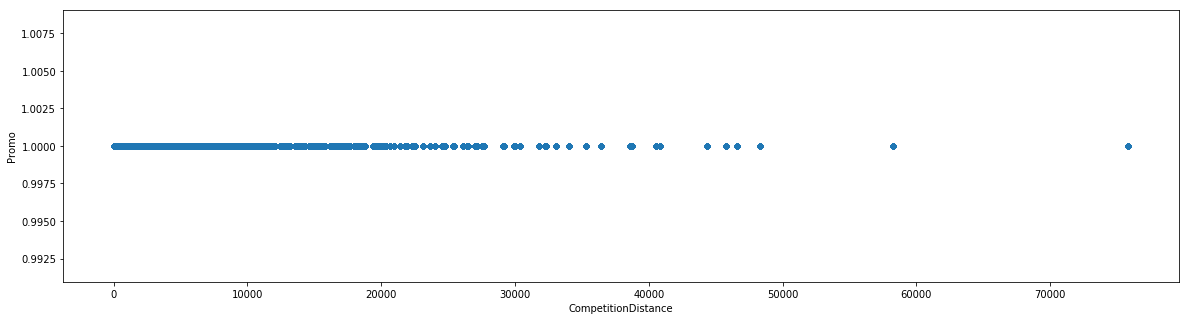

In [26]:
dfs1=train_store[['Promo','CompetitionDistance']]
dfs1= dfs1[dfs1["Promo"] != 0]
dfs1.plot.scatter(x='CompetitionDistance', y='Promo', legend=True, figsize=(20, 5))

From the first plot its clear that for low competition distance the sales value is higher. Althought the relatiosnhip is not clear from the first graph. However it appears that the stores who have competition Nearby, they are aggressively promoting their offers and hence more customers visit those stores resulting in more sales.

#### Conclusion from Exploratory Data Analysis

- The most selling and crowded StoreType is A.
- The best "Sale per Customer" StoreType D indicates to the higher Buyer Cart. To benefit from this fact, Rossmann can consider    proposing bigger variety of its products.
- Low SalePerCustomer amount for StoreType B indicates to the possible fact that people shop there essentially for "small"          things. 
- Customers tends to buy more on Modays when there's one promotion (Promo) and on Sundays when there's no promotion at all (both    Promo and Promo1 are equal to 0).
- Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount.
- B assortment type appears to make more sales value, they are very rare compared to other types.
- Customers tend to visit stores which has competition nearby as stores are aggressively promoting their promos in these areas.

<h2>References</h2>
<ul>
    <p>Notebooks</p>
    <li>https://www.kaggle.com/novikovanastya/submission-novikova</li>
    <li>https://www.kaggle.com/evgenyvasilyev/evgeny-vasilyev</li>
    <li>https://www.kaggle.com/dynamic22/rossman-store-sales-basic</li>
</ul>